In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re

import kplr

In [2]:
def all_LCdata(koi, mask_bad=True):
    df = pd.DataFrame()
    for lc in koi.get_light_curves():
        if re.search('_llc\.fits', lc.filename):
            newdf = lc.data
            newdf['PDCSAP_FLUX'] /= newdf['PDCSAP_FLUX'].mean()
            df = pd.concat([df, newdf])
            
    if mask_bad:
        ok = np.isfinite(df['PDCSAP_FLUX']) & (df['SAP_QUALITY']==0)
    return df[ok]

In [3]:
client = kplr.API()
koi = client.koi(1422.01)
lcdata = all_LCdata(koi)
period = koi.koi_period
epoch = koi.koi_time0bk
duration = koi.koi_duration
tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)

close = np.absolute(tfold) < 3*(duration/24)

In [28]:
from transit import Central, System, Body

KEPLER_CADENCE = 1626./86400

def t_folded(t, per, ep):
    return (t + per/2 - ep) % per - (per/2)

class TransitModel(object):
    """Object holding time/flux data allowing for simple transit fitting
    
    period, epoch are approximate guesses for the period/epoch
    of each planet in the system (should be the same length)
    """
    def __init__(self, time, flux, flux_err=0.0001,
                 period=None, epoch=None, 
                 texp=KEPLER_CADENCE,
                detrend_order=None):
        

        self.texp = texp
        
        if period is None:
            period = []
        if epoch is None:
            epoch = []
        
        if type(period)==float:
            period = [period]
        if type(epoch)==float:
            epoch = [epoch]
        
        assert len(period)==len(epoch)

        self.period = period
        self.epoch = epoch
        
        self.detrend_order = detrend_order

        # Organize data into 2-d array, where rows are subsequent transits.
        
        
        self._time = np.array(time)
        self._flux = np.array(flux)
        self._flux_err = np.array(flux_err)

        
    @property
    def time(self):
        return self._time.ravel()
    
    @property
    def flux(self):
        return self._flux.ravel()
        
    @property
    def flux_err(self):
        return self._flux_err.ravel()
        
    @property
    def n_planets(self):
        return len(self.period)
        
    def add_planet(self, period, epoch):
        self.period.append(period)
        self.epoch.append(epoch)
        
    def continuum(self, p, t):
        """out-of-transit light curve--- can in principle be variational model
        """
        return np.ones_like(t)
        
    def light_curve(self, p, t, edge=2):
        """
        params: [rhostar, q1, q2, dilution, [period, epoch, b, rprs, e, w]*nplanets]

        edge says how many "durations" from transit center to bother calculating.
        if eccentricity significant, you may need larger edge.
        """
        if self.n_planets==0:
            raise ValueError('Must add planet before evaluating light curve')

        self._pars = p
        self._duration_approx = [1.] * self.n_planets
    
        rhostar, q1, q2, dilution = p[:4]
        
        central = Central(q1=q1, q2=q2)
        central.density = rhostar
        s = System(central, dilution=dilution)
        
        tot = 0
        close_to_transit = np.zeros_like(t).astype(bool)
        for i in range(self.n_planets):
            period, epoch, b, rprs, e, w = p[4+i*6:10+i*6]
            r = central.radius * rprs
            body = Body(flux=0, r=r, mass=0, period=period, t0=epoch,
                       e=e, omega=w, b=b)
            s.add_body(body)
            
            tfold = t_folded(t, period, epoch)
            
            #because duration hack sometimes fails...
            try:
                duration = body.duration_approx
                self._duration_approx[i] = duration
            except:
                duration = self._duration_approx[i]
        
            close_to_transit += np.absolute(tfold) < edge*(duration)
        
        f = self.continuum(p, t)
        f[close_to_transit] = s.light_curve(t[close_to_transit], texp=self.texp)
        return f
            
    def lnlike(self, p):
        prior = self.lnprior(p)
        if np.isfinite(prior):
            flux_model = self.light_curve(p, self.time)
            return prior + (-0.5 * (flux_model - self.flux)**2 / self.flux_err**2).sum()
        else:
            return prior
    
    def lnprior(self, p):
        rhostar, q1, q2, dilution = p[:4]
        if not (0 <= q1 <=1 and 0 <= q2 <= 1):
            return -np.inf
        if rhostar < 0:
            return -np.inf
        if not (0 <= dilution < 1):
            return -np.inf
        
        for i in range(self.n_planets):
            period, epoch, b, rprs, e, w = p[4+i*6:10+i*6]
            if period <= 0:
                return -np.inf
            if not 0 <= e <= 1:
                return -np.inf
            if not 0 <= b < 1+rprs:
                return -np.inf
            if rprs < 0:
                return -np.inf
            
        return 0

In [29]:
client = kplr.API()

koi_list = [1422.01] #, 1422.02, 1422.03, 1422.04, 1422.05]

kois = []
periods = []
epochs = []
durations = []
for k in koi_list:
    kois.append(client.koi(k))
    periods.append(kois[-1].koi_period)
    epochs.append(kois[-1].koi_time0bk)
    durations.append(kois[-1].koi_duration)

lcdata = all_LCdata(kois[0])
flux = lcdata['PDCSAP_FLUX']
model = TransitModel(lcdata['TIME'], flux, lcdata['PDCSAP_FLUX_ERR'],
                    period=periods, epoch=epochs)



5.84164124 135.92243
250.0
193.0
48060
48250.0


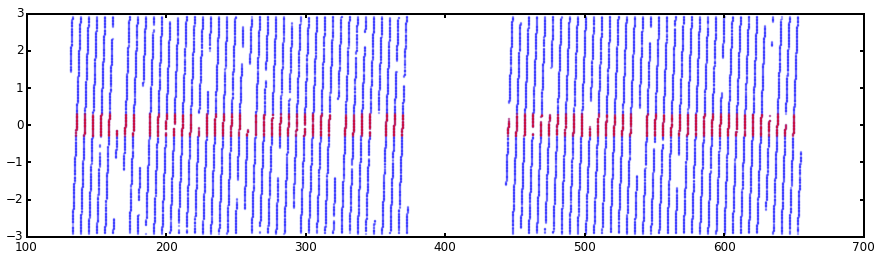

In [56]:
def transit_stack(t, f, period, epoch, width=0.3):
    """reshapes t, f to (Ntransit x npoint) 2d array
    
    Places the transit epoch at the center of each row,
    with the first and last rows padded by ones.
    
    
    """
    print period, epoch
    ntransits = ((t[-1] - t[0]) // period) + 1
    print ntransits

    rowsize = len(t)//ntransits + 1
    print rowsize
    print len(t)
    print 250*rowsize
    
    middle = rowsize//2
    # How many points do we need to add to the front to
    #  get epoch in middle?
    firstfew = t[:rowsize*100]
    i_epoch = np.argmin((firstfew - epoch) % period)
    
    tfold = (firstfew - epoch) % period
    tfold = t_folded(firstfew, period, epoch)
    close = np.absolute(tfold) < width
    plt.figure(figsize=(15,4))
    plt.plot(firstfew, tfold, '.', ms=0.5)
    plt.plot(firstfew[close], tfold[close], 'r.', ms=0.5)
    
transit_stack(model.time, model.flux, model.period[0], model.epoch[0])
    
    

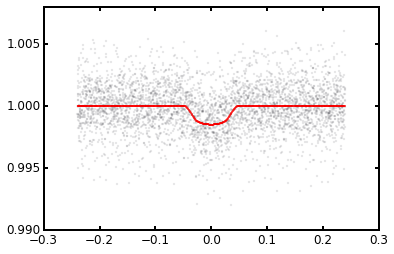

In [17]:
params = [kois[0].koi_srho, 0.5, 0.5, 0]
for k in kois:
    params += [k.koi_period, k.koi_time0bk, k.koi_impact, k.koi_ror, 0.01, 0]

    
anyclose = np.zeros_like(lcdata['TIME']).astype(bool)
for period, epoch, duration in zip(periods, epochs, durations):    
    tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)
    anyclose += np.array(np.absolute(tfold) < 3*(duration/24))

    
f = np.ones_like(lcdata['TIME'])
f[anyclose] = model.light_curve(params, lcdata['TIME'][anyclose])

for period, epoch, duration in zip(periods, epochs, durations):
    plt.figure()
    tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)
    close = np.array(np.absolute(tfold) < 3*(duration/24))
    plt.plot(tfold[close], flux[close], 'o', ms=0.2, alpha=0.35);
    plt.plot(tfold[close], f[close], 'ro', ms=0.2, mec='r', mew=0.5);

In [18]:
%timeit f[anyclose] = model.light_curve(params, lcdata['TIME'][anyclose])
%timeit f[~anyclose] = model.light_curve(params, lcdata['TIME'][~anyclose])
%timeit f = model.light_curve(params, lcdata['TIME'])

10 loops, best of 3: 131 ms per loop
100 loops, best of 3: 3.39 ms per loop
10 loops, best of 3: 133 ms per loop


In [20]:
from scipy.optimize import minimize
def obj(p):
    return -model.lnlike(p)

fit = minimize(obj, params, method='Nelder-Mead', options={'disp':True})

Optimization terminated successfully.
         Current function value: 0.006263
         Iterations: 696
         Function evaluations: 1143


[  4.72954152e+00   2.81073558e-01   5.87961813e-01   1.91477839e-04
   5.84164158e+00   1.35923004e+02   5.74815816e-01   3.54667764e-02
   9.97333917e-03   9.56463017e-04]


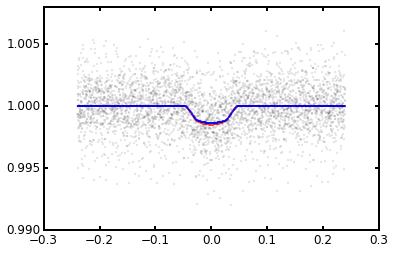

In [21]:
f_fit = np.ones_like(lcdata['TIME'])
f_fit[anyclose] = model.light_curve(fit.x, lcdata['TIME'][anyclose])

print fit.x

for period, epoch, duration in zip(periods, epochs, durations):
    plt.figure()
    tfold = (lcdata['TIME'] + period/2 - epoch) % period - (period/2)
    close = np.array(np.absolute(tfold) < 3*(duration/24))
    plt.plot(tfold[close], flux[close], 'o', ms=0.2, alpha=0.35);
    plt.plot(tfold[close], f[close], 'ro', ms=0.2, mec='r', mew=0.2);
    plt.plot(tfold[close], f_fit[close], 'bo', ms=0.2, mec='b', mew=0.4)

In [59]:
import emcee as emcee

ndim = len(params)
nwalkers = 100
p0 = (1 + np.random.normal(0,0.01,size=(ndim,nwalkers))) * np.array(params)[:,None]

sampler = emcee.EnsembleSampler(nwalkers, ndim, model.lnlike)

In [61]:
sampler.run_mcmc(p0, 10)

ValueError: low >= high